> 🚨 **WARNING** 🚨
>
> Many cells in this notebook will not show up when viewed on GitHub. Please view the HTML version of this notebook in the [docs](https://docs.rastervision.io/en/latest/usage/tutorials/index.html).

We will be accessing files on S3 in this notebook. Since those files are public, we set the `AWS_NO_SIGN_REQUEST` to tell `rasterio` to skip the sign-in.

In [ ]:
%env AWS_NO_SIGN_REQUEST=YES

# Sampling training data

## The `GeoDataset` class

---

First, let's define a handy plotting function:

In [1]:
def show_windows(img, windows, title=''):
    from matplotlib import pyplot as plt
    import matplotlib.patches as patches

    fig, ax = plt.subplots(1, 1, squeeze=True, figsize=(8, 8))
    ax.imshow(img)
    ax.axis('off')
    # draw windows on top of the image
    for w in windows:
        p = patches.Polygon(w.to_points(), color='r', linewidth=1, fill=False)
        ax.add_patch(p)
    ax.autoscale()
    ax.set_title(title)
    plt.show()

<hr style="border:2px solid gray">

### `SlidingWindowGeoDataset`

In [3]:
image_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif'
label_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson'

In [4]:
from rastervision.core.data import ClassConfig
from rastervision.pytorch_learner import (
    SemanticSegmentationSlidingWindowGeoDataset, SemanticSegmentationVisualizer)

import albumentations as A

class_config = ClassConfig(
    names=['background', 'building'], 
    colors=['lightgray', 'darkred'],
    null_class='background')

ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=image_uri,
    label_vector_uri=label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    image_raster_source_kw=dict(allow_streaming=True),
    size=200,
    stride=200,
    out_size=256,
)

2024-04-09 20:05:56:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson.


We can read a data sample and the corresponding ground truth from the Dataset like so:

In [5]:
x, y = ds[0]
x.shape, y.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

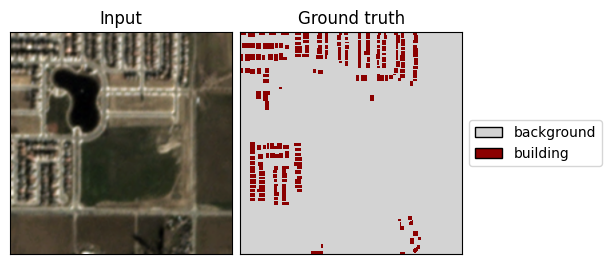

In [6]:
viz = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)
viz.plot_batch(x.unsqueeze(0), y.unsqueeze(0), show=True)

The above was the first sliding window in the dataset. We can visualize what the full set of windows looks like like so:

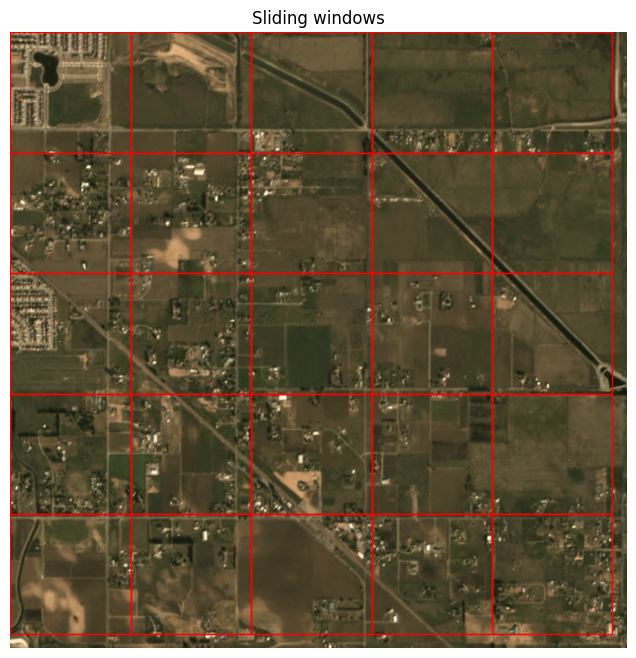

In [7]:
img_full = ds.scene.raster_source[:, :]
show_windows(img_full, ds.windows, title='Sliding windows')

<hr style="border:2px solid gray">

### RandomWindowGeoDataset

In [8]:
image_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif'
label_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson'

2024-04-09 20:06:18:rastervision.pipeline.file_system.utils: INFO - Using cached file /opt/data/tmp/cache/s3/spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson.


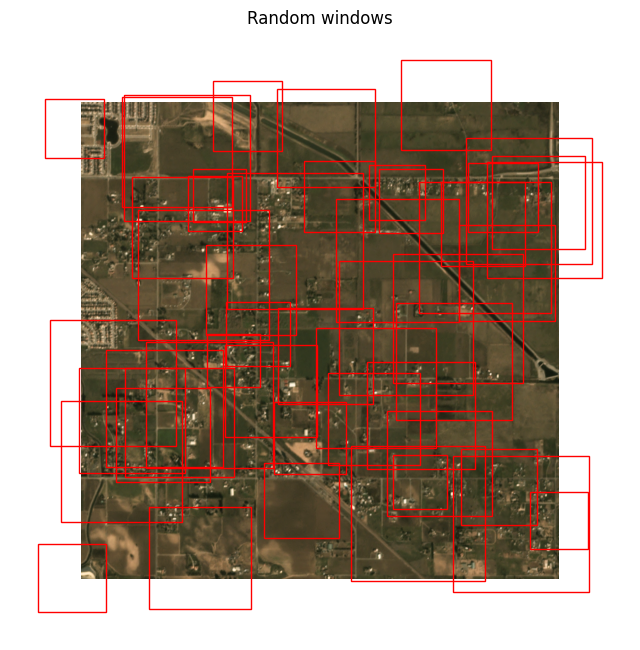

In [9]:
from rastervision.core.data import ClassConfig
from rastervision.pytorch_learner import SemanticSegmentationRandomWindowGeoDataset

import albumentations as A

class_config = ClassConfig(
    names=['background', 'building'], 
    colors=['lightgray', 'darkred'],
    null_class='background')

ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=image_uri,
    label_vector_uri=label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    image_raster_source_kw=dict(allow_streaming=True),
    # window sizes will randomly vary from 100x100 to 300x300
    size_lims=(100, 300),
    # resize chips to 256x256 before returning
    out_size=256,
    # allow windows to overflow the extent by 100 pixels
    padding=100
)

img_full = ds.scene.raster_source[:, :]
windows = [ds.sample_window() for _ in range(50)]
show_windows(img_full, windows, title='Random windows')

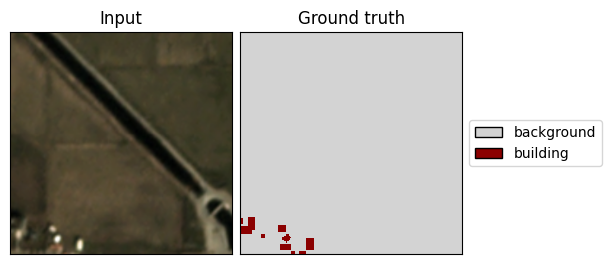

In [10]:
x, y = ds[0]
viz.plot_batch(x.unsqueeze(0), y.unsqueeze(0), show=True)